In [3]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [4]:
from pyTVDN import TVDNDetect
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import lfilter, firls, decimate
from tqdm import tqdm
from easydict import EasyDict as edict
from collections import Counter
import pickle
import pandas as pd
import scipy.stats as ss
from collections import defaultdict as ddict

%matplotlib inline

In [5]:
def minmax(x):
    num = x - np.min(x)
    den = np.max(x) - np.min(x)
    return num/den  

In [6]:
resDir = Path("./results")
dataDir = Path("../data")

### Load results 

In [7]:
def BarResFn(numList):
    numCts = Counter(numList)
    kys = list(numCts.keys())
    kys = sorted(kys)
    Cts = [numCts[ky] for ky in kys]
    Freqs = np.array(Cts)/np.sum(Cts)
    res = edict()
    res.kys = kys
    res.Cts = Cts
    res.Freqs = Freqs
    return res

In [8]:
with open("../results/fMRIHPFs_sep/fMRIResultAdap_healthy.pkl", "rb") as f:
    results = pickle.load(f)

In [9]:
numChgs = []
numRanks = []
for DetObj in results.DetObjs:
    numChgs.append(len(DetObj.ecpts))
    numRanks.append(DetObj.paras.r)

## Distribution of num of change points

In [10]:
chgsBoth = BarResFn(numChgs)
chgsHalf1 = BarResFn(numChgs[:52])
chgsHalf2 = BarResFn(numChgs[52:])

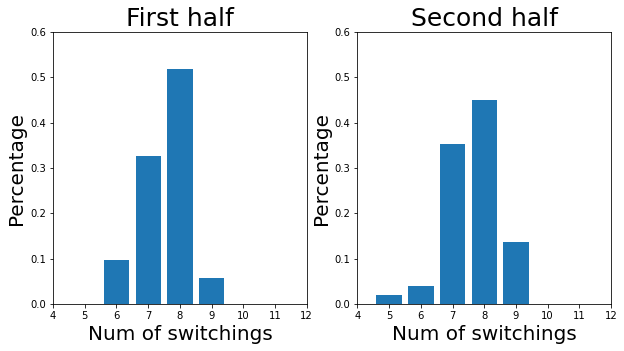

In [22]:
plt.figure(figsize=[10, 5])

# plt.subplot(131)
# plt.title("All data", fontsize=25)
# plt.bar(chgsBoth.kys, chgsBoth.Freqs)
# plt.xlabel("Num of switchings", fontsize=20)
# plt.ylabel("Percentage", fontsize=20)
# plt.xlim([4, 12])
# plt.ylim([0, 0.6])

plt.subplot(121)
plt.title("First half", fontsize=25)
plt.bar(chgsHalf1.kys, chgsHalf1.Freqs)
plt.xlabel("Num of switchings", fontsize=20)
plt.ylabel("Percentage", fontsize=20)
plt.xlim([4, 12])
plt.ylim([0, 0.6])

plt.subplot(122)
plt.title("Second half", fontsize=25)
plt.bar(chgsHalf2.kys, chgsHalf2.Freqs)
plt.xlabel("Num of switchings", fontsize=20)
plt.ylabel("Percentage", fontsize=20)
plt.xlim([4, 12])
plt.ylim([0, 0.6])

plt.savefig(f"./plots/fMRI_sep_numChgs.jpg", bbox_inches='tight')

## Distribution of num of ranks

In [12]:
rankBoth = BarResFn(numRanks)
rankHalf1 = BarResFn(numRanks[:52])
rankHalf2 = BarResFn(numRanks[52:])

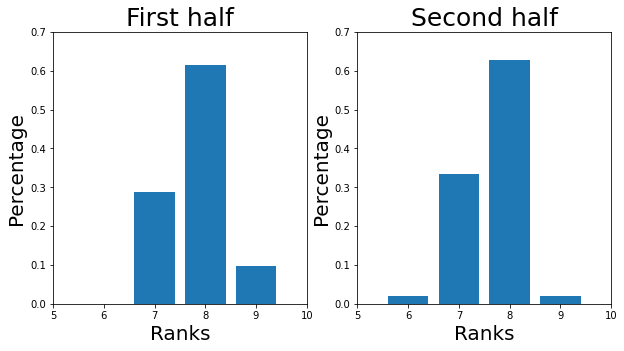

In [21]:
plt.figure(figsize=[10, 5])

# plt.subplot(131)
# plt.title("All data", fontsize=25)
# plt.bar(rankBoth.kys, rankBoth.Freqs)
# plt.xlabel("Ranks", fontsize=20)
# plt.ylabel("Percentage", fontsize=20)
# plt.xlim([5, 10])
# plt.ylim([0, 0.7])


plt.subplot(121)
plt.title("First half", fontsize=25)
plt.bar(rankHalf1.kys, rankHalf1.Freqs)
plt.xlabel("Ranks", fontsize=20)
plt.ylabel("Percentage", fontsize=20)
plt.xlim([5, 10])
plt.ylim([0, 0.7])

plt.subplot(122)
plt.title("Second half", fontsize=25)
plt.bar(rankHalf2.kys, rankHalf2.Freqs)
plt.xlabel("Ranks", fontsize=20)
plt.ylabel("Percentage", fontsize=20)
plt.xlim([5, 10])
plt.ylim([0, 0.7])

plt.savefig(f"./plots/fMRI_sep_ranks.jpg", bbox_inches='tight')

## Violin plot

### The conanical networks

In [14]:
fcRDF = pd.read_csv("../data/fMRI_labels/AALICA.csv")
fcR = np.array(fcRDF)[:90, :]
names = list(fcRDF.columns)
names = [name.strip() for name in names]

fcR = np.array([minmax(fcR[:, i]) for i in range(7)])
fcR = fcR.T

In [15]:
Us = []
cFlag = 0
for idx, DetObj in enumerate(results.DetObjs):
    r = DetObj.paras.r
    rUs = DetObj.midRes.eigVecs[:, :r]
    kpidxs = np.where(np.diff(np.concatenate([[np.Inf], np.abs(rUs[0, :])])) != 0)[0]
    for ix in kpidxs:
        Us.append(rUs[:, ix])
        if idx < 52:
            cFlag += 1
        
absUs = np.array(np.abs(Us))
absUsList =[minmax(absUs[i, :]) for i in range(absUs.shape[0])]
absUs = np.array(absUsList)

In [17]:
corrs = ddict(list)
for absU in absUs:
    for j, name in enumerate(names):
        corrs[name].append(ss.pearsonr(fcR[:, j], absU)[0])
        
corDF = pd.DataFrame(corrs)
corArr = np.array(corDF)

In [18]:
corArrMax = np.max(corArr, axis=1)
corArrMaxHalf1 = corArrMax[:cFlag]
corArrMaxHalf2 = corArrMax[cFlag:]

In [24]:
rawVs = list(corArrMaxHalf1) + list(corArrMaxHalf2)
violabs = ["First half"]*len(corArrMaxHalf1) +  ["Second half"]*len(corArrMaxHalf2)

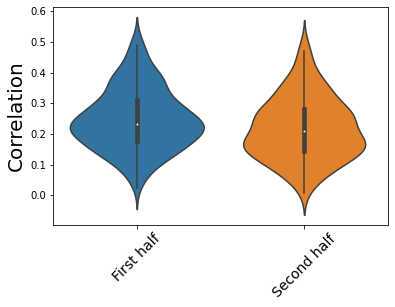

In [25]:
plt.figure(figsize=[6, 4])
sns.violinplot(y=rawVs, x=violabs)
plt.ylabel("Correlation", fontsize=20)
plt.xticks(color="black", fontsize=14, rotation=45)
plt.savefig("./plots/fMRI_sep_violin.jpg", bbox_inches='tight')